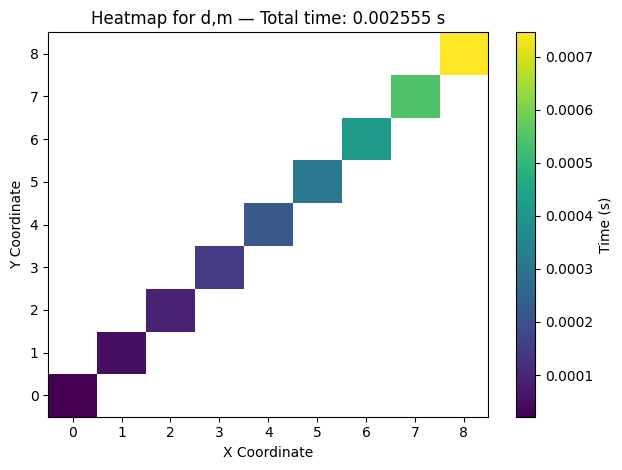

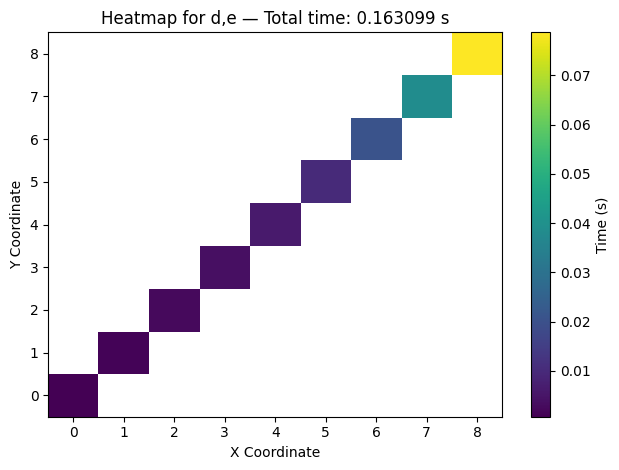

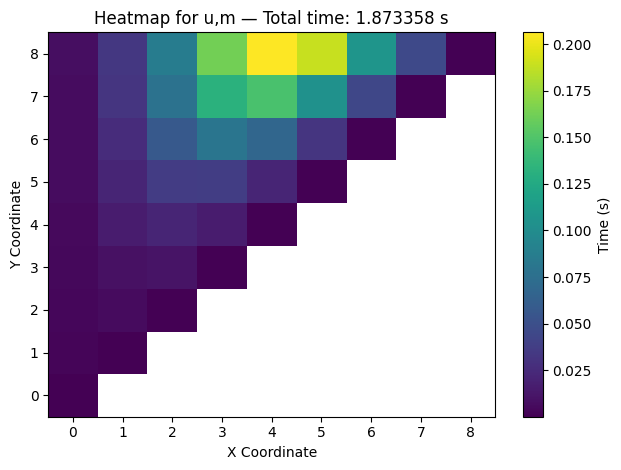

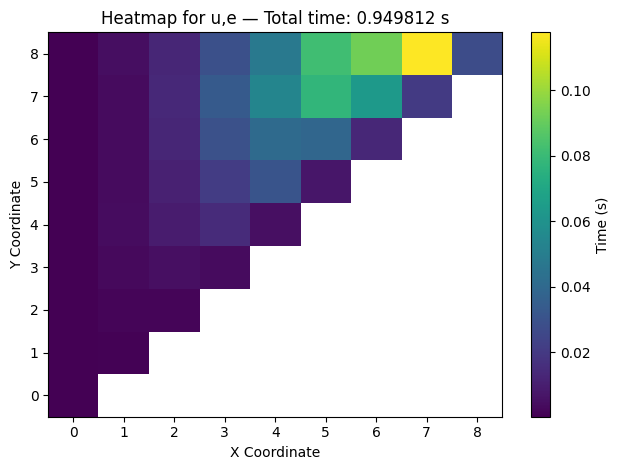

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(
    'timings_2.csv',
    header=None,
    names=['option1', 'option2', 'x', 'y', 'time']
)

# Cast types
df['x'] = df['x'].astype(int)
df['y'] = df['y'].astype(int)
df['time'] = df['time'].astype(float)

# Define the four (option1, option2) pairs
combinations = [('d', 'm'), ('d', 'e'), ('u', 'm'), ('u', 'e')]

for opt1, opt2 in combinations:
    subset = df[(df['option1'] == opt1) & (df['option2'] == opt2)]
    if subset.empty:
        print(f"No data for ({opt1}, {opt2})")
        continue

    # Sum times
    total = subset['time'].sum()

    # Pivot into a 2D grid: rows = y, columns = x
    pivot = subset.pivot(index='y', columns='x', values='time')

    plt.figure()
    plt.imshow(pivot.values, origin='lower', aspect='auto')
    plt.title(f'Heatmap for {opt1},{opt2} — Total time: {total:.6f} s')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.colorbar(label='Time (s)')
    plt.tight_layout()
    plt.show()


In [2]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt 

def plot_timings(pattern="timings_*_*.csv", step_col="step", time_col="time_s"):
    files = glob.glob(pattern)
    if not files:
        print(f"No files matching {pattern} in cwd: {os.getcwd()}")
        return

    df_list = []
    per_file_totals = {}

    for fn in sorted(files):
        if os.path.getsize(fn) == 0:
            print(f"Skipping empty file: {fn}")
            continue
        try:
            tmp = pd.read_csv(fn)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty (no data): {fn}")
            continue
        if step_col not in tmp or time_col not in tmp:
            print(f"Skipping {fn}: missing columns {step_col},{time_col}")
            continue

        # sum per step in this file
        file_totals = tmp.groupby(step_col)[time_col].sum().reset_index()
        per_file_totals[fn] = file_totals
        df_list.append(tmp[[step_col, time_col]])

    if not df_list:
        print("No valid timing data found.")
        return

    # overall aggregation
    all_df = pd.concat(df_list, ignore_index=True)
    aggregated = all_df.groupby(step_col)[time_col].sum().reset_index()

    # plot each file
    for fn, df_totals in per_file_totals.items():
        plt.figure(figsize=(6,4))
        plt.bar(df_totals[step_col], df_totals[time_col])
        plt.title(f"Per-file totals: {fn}")
        plt.xlabel("Step")
        plt.ylabel("Total Time (s)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    
    # plot aggregated
    plt.figure(figsize=(6,4))
    plt.bar(aggregated[step_col], aggregated[time_col])
    plt.title("Aggregated totals across all files")
    plt.xlabel("Step")
    plt.ylabel("Total Time (s)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# call it
plot_timings()


No files matching timings_*_*.csv in cwd: /Users/marcelmasque/University/other/persistent_laplacians


# How fast is primme, how fast is scipy?

In [3]:
import time
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh as scipy_eigsh
import primme

def make_sparse_symm(n, density=0.005, random_state=42):
    rng = np.random.default_rng(random_state)
    # generate random sparse matrix
    rvs = rng.standard_normal
    A = sp.random(n, n, density=density, data_rvs=rvs, random_state=rng, format='csr')
    # symmetrize
    A = (A + A.T) / 2
    return A

def compute_with_primme(A):
    # PRIMME: compute 1 smallest algebraic eigenvalue
    start = time.perf_counter()
    vals, vecs, info = primme.eigsh(A, k=1, which='SM', return_stats=True)
    elapsed = time.perf_counter() - start
    return float(vals[0]), elapsed

def compute_with_scipy(A):
    # SciPy: shift-invert to get smallest eigenvalue (sigma=0)
    start = time.perf_counter()
    vals, vecs = scipy_eigsh(A, k=1, sigma=0.0001, which='LM')
    elapsed = time.perf_counter() - start
    return float(vals[0]), elapsed

# create test matrix
n = 2000
A = make_sparse_symm(n, density=0.001)

# run PRIMME
# primme_val, primme_time = compute_with_primme(A)
# print(f"PRIMME:   λ_min = {primme_val:.8e}, time = {primme_time:.4f} s")

# run SciPy
scipy_val, scipy_time = compute_with_scipy(A)
print(f"SciPy:    λ_min = {scipy_val:.8e}, time = {scipy_time:.4f} s")


SciPy:    λ_min = 1.22729321e-04, time = 0.0866 s
